In [12]:
#from test_models.novel_deeplabV3withSE import UNetDeeplab

ImportError: cannot import name 'UNetDeeplab' from 'test_models.novel_deeplabV3withSE' (/home/maitha.alnaqbi/Desktop/ai702_project/test_models/novel_deeplabV3withSE.py)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pandas as pd
from PIL import Image
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pandas as pd
from PIL import Image
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from typing import Any
from typing import List

In [50]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class UNetDeeplab(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(UNetDeeplab, self).__init__()

        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)

        if input_channel != 3:
            self.model.backbone.conv1 = nn.Conv2d(input_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.classifier[4] = nn.Conv2d(256, output_channel, kernel_size=1, stride=1)

        for m in self.model.backbone.modules():
            if isinstance(m, models.resnet.Bottleneck):
                m.conv3 = nn.Sequential(m.conv3, SELayer(m.conv3.out_channels))

    def forward(self, x):
        features = self.model(x)['out']
        return features

In [25]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        mask_name = self.data.iloc[idx, 1]
        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0.5).float()

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/train_data.csv"
test_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/test/test_data.csv"

train_dataset = CustomDataset(train_csv_file, transform=transform)
test_dataset = CustomDataset(test_csv_file, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, drop_last=True)

val_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/val/val_data.csv"
val_dataset = CustomDataset(val_csv_file, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

Epoch 1/100, Train Loss: 0.2190, Val Loss: 0.0971, Mean Dice: 0.0158, Mean IoU: 0.8154, Pearson Correlation: 0.0215
Epoch 2/100, Train Loss: 0.0630, Val Loss: 0.0544, Mean Dice: 0.0514, Mean IoU: 0.8167, Pearson Correlation: 0.0745
Epoch 3/100, Train Loss: 0.0394, Val Loss: 0.0420, Mean Dice: 0.1129, Mean IoU: 0.8163, Pearson Correlation: 0.1441
Epoch 4/100, Train Loss: 0.0324, Val Loss: 0.0353, Mean Dice: 0.0560, Mean IoU: 0.8168, Pearson Correlation: 0.0872
Epoch 5/100, Train Loss: 0.0274, Val Loss: 0.0314, Mean Dice: 0.2246, Mean IoU: 0.8145, Pearson Correlation: 0.2674
Epoch 6/100, Train Loss: 0.0243, Val Loss: 0.0291, Mean Dice: 0.1545, Mean IoU: 0.8163, Pearson Correlation: 0.2040
Epoch 7/100, Train Loss: 0.0225, Val Loss: 0.0294, Mean Dice: 0.3362, Mean IoU: 0.7939, Pearson Correlation: 0.3570
Epoch 8/100, Train Loss: 0.0203, Val Loss: 0.0323, Mean Dice: 0.2290, Mean IoU: 0.8238, Pearson Correlation: 0.2822
Epoch 9/100, Train Loss: 0.0191, Val Loss: 0.0351, Mean Dice: 0.2516, Me

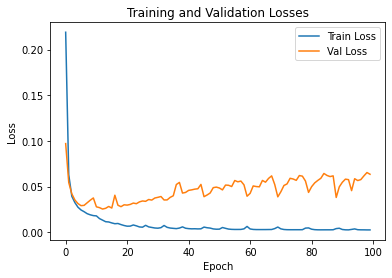

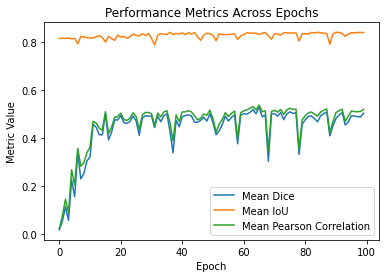

In [18]:
def dice_coeff(pred, target):
    smooth = 1.0
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou(pred, target):
    pred = pred.bool() 
    target = target.bool()
    intersection = (pred & target).sum((1, 2))
    union = (pred | target).sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

dev = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetDeeplab(input_channel=3, output_channel=1).to(dev)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

mean_dice_scores = []
mean_iou_scores = []
mean_pearson_correlation = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        #print(f"Batch {batch_idx}, Input shape: {images.shape}")
        optimizer.zero_grad()
        outputs = model(images.to(dev))
        loss = loss_function(outputs, masks.to(dev))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    total_dice, total_iou, total_pearson = 0, 0, 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images.to(dev))
            val_loss = loss_function(outputs, masks.to(dev))
            total_val_loss += val_loss.item()
            
            outputs_thresh = torch.sigmoid(outputs) > 0.5
            total_dice += dice_coeff(outputs_thresh, masks.to(dev)).item()
            
            total_iou += iou(outputs_thresh, masks.to(dev)).mean().item()
            
            outputs_np = outputs_thresh.view(-1).cpu().numpy()
            masks_np = masks.view(-1).cpu().numpy()
            pearson_corr, _ = pearsonr(outputs_np, masks_np)
            if not np.isnan(pearson_corr):
                total_pearson += pearson_corr

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_dice = total_dice / len(test_loader)
    mean_dice_scores.append(avg_dice)
    
    avg_iou = total_iou / len(test_loader)
    mean_iou_scores.append(avg_iou)
    
    avg_pearson = total_pearson / len(test_loader)
    mean_pearson_correlation.append(avg_pearson)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}, Pearson Correlation: {avg_pearson:.4f}')

torch.save(model.state_dict(), 'novel1_deeplab50_with_bce_loss.pth')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.plot(mean_dice_scores, label='Mean Dice')
plt.plot(mean_iou_scores, label='Mean IoU')
plt.plot(mean_pearson_correlation, label='Mean Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Epochs')
plt.legend()
plt.savefig('performance_metrics_plot.png')
plt.show()

Epoch 1/100, Train Loss: 0.2002, Val Loss: 0.0969, Mean Dice: 0.0023, Mean IoU: 0.8148, Pearson Correlation: 0.0029
Epoch 2/100, Train Loss: 0.0591, Val Loss: 0.0581, Mean Dice: 0.0975, Mean IoU: 0.8055, Pearson Correlation: 0.1282
Epoch 3/100, Train Loss: 0.0375, Val Loss: 0.0457, Mean Dice: 0.0925, Mean IoU: 0.8187, Pearson Correlation: 0.1355
Epoch 4/100, Train Loss: 0.0297, Val Loss: 0.0473, Mean Dice: 0.0976, Mean IoU: 0.8149, Pearson Correlation: 0.1407
Epoch 5/100, Train Loss: 0.0249, Val Loss: 0.0404, Mean Dice: 0.3706, Mean IoU: 0.7982, Pearson Correlation: 0.3845
Epoch 6/100, Train Loss: 0.0212, Val Loss: 0.0435, Mean Dice: 0.3232, Mean IoU: 0.8059, Pearson Correlation: 0.3443
Epoch 7/100, Train Loss: 0.0177, Val Loss: 0.0408, Mean Dice: 0.2925, Mean IoU: 0.8152, Pearson Correlation: 0.3251
Epoch 8/100, Train Loss: 0.0150, Val Loss: 0.0580, Mean Dice: 0.3308, Mean IoU: 0.8189, Pearson Correlation: 0.3530
Epoch 9/100, Train Loss: 0.0130, Val Loss: 0.0445, Mean Dice: 0.3691, Me

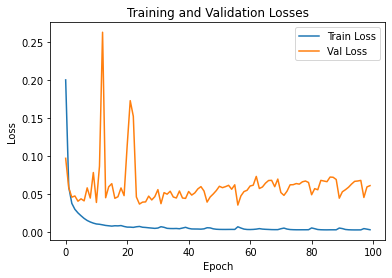

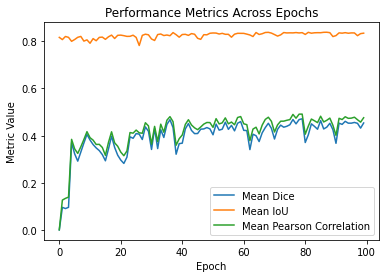

In [51]:
def dice_coeff(pred, target):
    smooth = 1.0
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou(pred, target):
    pred = pred.bool() 
    target = target.bool()
    intersection = (pred & target).sum((1, 2))
    union = (pred | target).sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

dev = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetDeeplab(input_channel=3, output_channel=1).to(dev)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

mean_dice_scores = []
mean_iou_scores = []
mean_pearson_correlation = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        #print(f"Batch {batch_idx}, Input shape: {images.shape}")
        optimizer.zero_grad()
        outputs = model(images.to(dev))
        loss = loss_function(outputs, masks.to(dev))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    total_dice, total_iou, total_pearson = 0, 0, 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images.to(dev))
            val_loss = loss_function(outputs, masks.to(dev))
            total_val_loss += val_loss.item()
            
            outputs_thresh = torch.sigmoid(outputs) > 0.5
            total_dice += dice_coeff(outputs_thresh, masks.to(dev)).item()
            
            total_iou += iou(outputs_thresh, masks.to(dev)).mean().item()
            
            outputs_np = outputs_thresh.view(-1).cpu().numpy()
            masks_np = masks.view(-1).cpu().numpy()
            pearson_corr, _ = pearsonr(outputs_np, masks_np)
            if not np.isnan(pearson_corr):
                total_pearson += pearson_corr

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_dice = total_dice / len(test_loader)
    mean_dice_scores.append(avg_dice)
    
    avg_iou = total_iou / len(test_loader)
    mean_iou_scores.append(avg_iou)
    
    avg_pearson = total_pearson / len(test_loader)
    mean_pearson_correlation.append(avg_pearson)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}, Pearson Correlation: {avg_pearson:.4f}')

torch.save(model.state_dict(), 'novel2_deeplab50_with_bce_loss.pth')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.plot(mean_dice_scores, label='Mean Dice')
plt.plot(mean_iou_scores, label='Mean IoU')
plt.plot(mean_pearson_correlation, label='Mean Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Epochs')
plt.legend()
plt.savefig('performance_metrics_plot.png')
plt.show()